In [ ]:
# !pip install fastai

In [ ]:
# https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5  (color changes while viewing using openCV)

# https://towardsdatascience.com/color-identification-in-images-machine-learning-application-b26e770c4c71 
after the line "img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)" ,
add this & cross-check "image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)" 

# Fastai-based implementation of brightness augmentation
# https://github.com/albumentations-team/albumentations
# https://colab.research.google.com/drive/1JuZ23u0C0gx93kV0oJ8Mq0B6CBYhPLXy#scrollTo=GwFN-In3iagp&forceEdit=true&offline=true&sandboxMode=true 


# another lib https://github.com/aleju/imgaug 
# GitHub - ildoonet/unsupervised-data-augmentation: Unofficial PyTorch Implementation of Unsupervised Data Augmentation.

In [182]:
# auto-updating
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Setting Random Seed and Using CUDA for GPU Processing

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import glob
from sklearn.preprocessing import LabelEncoder
import os
import torch
import fastai
import time
from fastai.vision import *
np.random.seed(0) 
from torchvision.models import resnet50
from torchvision.models import mobilenet_v2
from torchvision.models import vgg16
from fastai.callbacks import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from fastai import *
# from fastai.dataset import ModelData,ArraysIndexDataset
# from fastai.dataloader import DataLoader
# from fastai.learner import Learner

import torch
import torch.nn as nn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def random_seed(seed_value, use_cuda):  
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    torch.backends.cudnn.deterministic = True

    if use_cuda: torch.cuda.manual_seed_all(seed_value) 

# Set seed
#random_seed(0,False)
random_seed(0,True)

In [184]:
#from fastai.callbacks import CSVLogger

In [185]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA_LAUNCH_BLOCKING=1

CUDA Available? True


In [186]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [ ]:
# Set batch size of images 
bs = 4
 #32  #64

#image_path = Path(r"C:\Users\Desktop\Projects\Classification Codes\data\IMAGES\train")
image_path = Path(r"C:\Users\Desktop\Projects\Augmented_Images")

image_path.ls()

In [ ]:
## load data
# fastai is automatically supposed to handle image format conversions- greyscale(L), RGB

# https://forums.fast.ai/t/how-to-load-images-as-grayscale/36895/6
# google: can fastai convert greyscale images to RGB

data = ImageDataBunch.from_folder(image_path, 
                                  valid_pct=0.4,
                                  ds_tfms=get_transforms(), 
                                  size=512, 
                                  bs=bs, 
                                  num_workers=1,
                                  seed=9).normalize(imagenet_stats)

In [190]:
data.classes
data.c
len(data.train_ds)
len(data.valid_ds)

['Good', 'Grind', 'Induction', 'Stain']

4

325

216

In [191]:
# count no. of examples in train & validation sets 
# train set
vc = pd.value_counts(data.train_ds.y.items, sort =False)
vc.index = data.classes
vc
# ratio

Good         208
Grind         17
Induction     77
Stain         23
dtype: int64

In [192]:
# val set
vc = pd.value_counts(data.valid_ds.y.items, sort =False)
# vc.index = data.classes
vc
# ratio

0    152
1      8
2     39
3     17
dtype: int64

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [194]:
precision = Precision()
recall = Recall()
metrics = [accuracy,precision,recall]

### MobileNet_V2  Two Call backs

In [95]:
#callback_fn=partial(CSVLogger, filename=f'sample_history_stage1')

In [198]:
# Initialize cnn_learner object with the right model and its pretrained weights
learn = cnn_learner(data, mobilenet_v2, pretrained=True, metrics=metrics, cut=-1,callback_fns=[partial(CSVLogger)])


learn.loss_func = torch.nn.functional.cross_entropy
# learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)
#cb=CSVLogger(learn)

#EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=3),
callbacks = [EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=3),
             SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='Mobile_Net')]
learn.callbacks = callbacks

In [199]:
#learn.recorder.plot(suggestion=True)
#learn.path

In [200]:
# Fit one cycle method for a number of epochs
epochs = 20
learn.fit_one_cycle(epochs)
#torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.244672,1.050947,0.550926,0.402936,0.433471,02:18
1,1.648743,0.532768,0.800926,0.607308,0.719204,02:17
2,1.323486,0.796445,0.689815,0.533994,0.552696,02:18
3,1.061191,0.462682,0.814815,0.565153,0.534410,02:18
4,1.095197,0.391652,0.851852,0.680155,0.595047,02:19
5,0.995566,0.315395,0.870370,0.679840,0.679629,02:19
6,0.885524,0.240972,0.902778,0.796066,0.700943,02:18
7,0.769106,0.211337,0.930556,0.869063,0.787849,02:18
8,0.753756,0.288759,0.898148,nan,0.648431,02:17
9,0.821236,0.306187,0.902778,0.905070,0.699708,02:19


Better model found at epoch 0 with valid_loss value: 1.0509474277496338.


c:\users\nei3kor\appdata\local\programs\python\python36\lib\site-packages\fastai\metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 1 with valid_loss value: 0.5327682495117188.
Better model found at epoch 3 with valid_loss value: 0.4626822769641876.
Better model found at epoch 4 with valid_loss value: 0.3916517496109009.
Better model found at epoch 5 with valid_loss value: 0.3153954744338989.
Better model found at epoch 6 with valid_loss value: 0.24097177386283875.
Better model found at epoch 7 with valid_loss value: 0.2113373875617981.
Better model found at epoch 10 with valid_loss value: 0.1716371476650238.
Better model found at epoch 11 with valid_loss value: 0.12819597125053406.
Epoch 15: early stopping


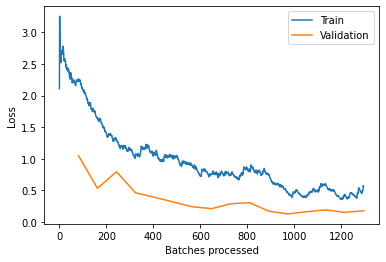

In [201]:
learn.recorder.plot_losses()

In [202]:
# Get the predictions for validation set and store as numpy array
preds = learn.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn.get_preds()[1].numpy()

# Get the predictions for training set and store as numpy array
train_pred = learn.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn.get_preds(ds_type=DatasetType.Train)[1].numpy()

# Calculate accuracy_score and append to Dataframe
val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)



In [203]:
val_acc, train_acc

(0.9537037037037037, 0.4691358024691358)

In [204]:
train_pred.shape, train_actual.shape

((324,), (324,))

In [205]:
preds.shape, test_actual.shape

((216,), (216,))

In [206]:
confusion_matrix(test_actual, preds)

array([[152,   0,   0,   0],
       [  0,   7,   0,   1],
       [  1,   0,  37,   1],
       [  1,   5,   1,  10]], dtype=int64)

In [149]:
confusion_matrix(train_actual, train_pred)

array([[62,  7, 25,  4],
       [ 7,  2,  2,  1],
       [25,  2,  8,  4],
       [ 9,  2,  3,  1]], dtype=int64)

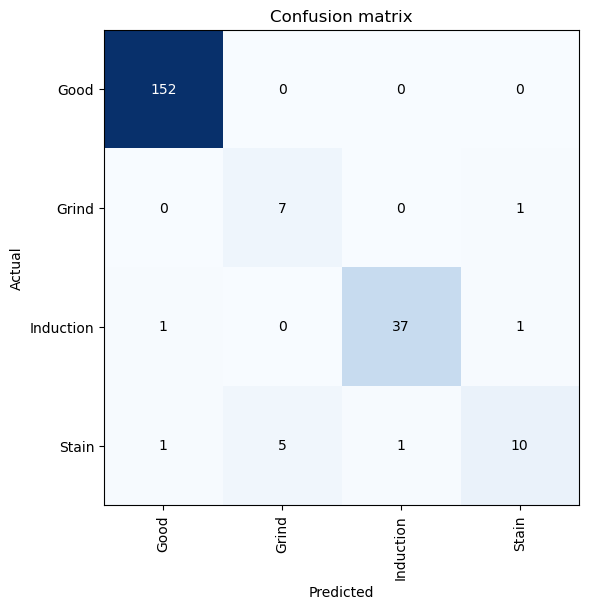

In [207]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [ ]:
learn.export(r"C:\Users\Desktop\Projects\classification\Data\mobilenetv2_Callbacks_20Augmentation.pkl")
#learn.save(os.path.join(model_save_path,'/resnet34_nocrk6000_epc2_stage-2'))

learn.save(r'C:\Users\Desktop\Projects\classification\Data\mobilenetv2_Callbacks_20Augmentation')

### Testing on New Images

In [ ]:
learn.load(r'C:\Users\Desktop\Projects\classification\Data\mobilenetv2_Callbacks_20Augmentation')

In [220]:
# predicting on a separate set, with labeled data
# use this method if there are several folders withing test folder

test_directory = r'C:\Users\Desktop\Projects\classification\Data\Test'
images = []

for r, d, f in os.walk(test_directory):
    for file in f:
        #if file.endswith(".docx"):
        images.append(os.path.join(r, file))


In [ ]:
images

In [ ]:
from fastai.vision import image
pred = []

for i in images:
    #img = image.open_image(test_directory+i)   # NameError: name 'image' is not defined  if image is not imported
    img = image.open_image(i)
    pred_class,pred_idx,outputs = learn.predict(img)
    pred.append(str(pred_class))

In [223]:
actual = []

for item in images:   # can be used if images are in sub-folders within test
#for item in os.listdir(test_directory):  # only when images are directly in "test"
    if 'Grind' in item:
        actual.append('Grind')
    if 'Induction' in item:
        actual.append('Induction')
    if 'Rust' in item:
        actual.append('Stain')
    if 'GOOD' in item:
        actual.append('Good')          

In [224]:
actual

['Grind',
 'Grind',
 'Induction',
 'Induction',
 'Induction',
 'Stain',
 'Stain',
 'Stain',
 'Good',
 'Good',
 'Good',
 'Good']

In [225]:
pred

['Grind',
 'Grind',
 'Induction',
 'Induction',
 'Grind',
 'Stain',
 'Stain',
 'Grind',
 'Good',
 'Good',
 'Good',
 'Good']

In [226]:
Test_Results={}

In [227]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

class_names = ['Good', 'Grind', 'Induction', 'Stain']
report=classification_report(actual, pred, target_names=class_names)
Classifiaction_Report=classification_report(actual, pred, target_names=class_names)
Test_Results["Classification Report"]=Classifiaction_Report

In [228]:
print(Classifiaction_Report)

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00         4
       Grind       0.50      1.00      0.67         2
   Induction       1.00      0.67      0.80         3
       Stain       1.00      0.67      0.80         3

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.82        12
weighted avg       0.92      0.83      0.84        12



# Mobile Net -One call back

In [16]:
# Initialize cnn_learner object with the right model and its pretrained weights
learn = cnn_learner(data, mobilenet_v2, pretrained=True, metrics=metrics, cut=-1)

learn.loss_func = torch.nn.functional.cross_entropy
# learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)

callbacks = [EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=3)]
learn.callbacks = callbacks

In [ ]:
# Fit one cycle method for a number of epochs
epochs = 5
learn.fit_one_cycle(epochs)
#torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')

In [98]:
#Ref
def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df

In [173]:
Accuracy_Score=accuracy_score(actual, pred)
Test_Results["Accuracy_Score"]=Accuracy_Score

In [184]:
import pandas as pd
Confusion_Matrix_List=[]
Confusion_matrix=pd.DataFrame(confusion_matrix(actual,pred,labels=class_names))
for index, row in Confusion_matrix.iterrows():
    Confusion_Matrix_List.append(list(row))
Test_Results["Confusion_Matrix"]=Confusion_Matrix_List

In [185]:
Test_Results

{'Classification Report': {'Cr': {'precision': 0.9090909090909091,
   'recall': 1.0,
   'f1-score': 0.9523809523809523,
   'support': 10},
  'In': {'precision': 0.9090909090909091,
   'recall': 1.0,
   'f1-score': 0.9523809523809523,
   'support': 10},
  'Pa': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10},
  'PS': {'precision': 1.0,
   'recall': 0.9,
   'f1-score': 0.9473684210526316,
   'support': 10},
  'RS': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10},
  'Sc': {'precision': 1.0,
   'recall': 0.9,
   'f1-score': 0.9473684210526316,
   'support': 10},
  'accuracy': 0.9666666666666667,
  'macro avg': {'precision': 0.9696969696969697,
   'recall': 0.9666666666666668,
   'f1-score': 0.9665831244778613,
   'support': 60},
  'weighted avg': {'precision': 0.9696969696969696,
   'recall': 0.9666666666666667,
   'f1-score': 0.9665831244778613,
   'support': 60}},
 'Accuracy_Score': 0.9666666666666667,
 'Confusion_Matrix': [[10, 0, 0, 0, 0, 0],
  [0, 1

In [186]:
import json
with open('data.json', 'w') as f:
    json.dump(Test_Results, f)

In [ ]:
#o read json
import json
with open('data.json',"r") as f:
    json.load(f)

<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization
[[10  0  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  0 10  0  0  0]
 [ 1  0  0  9  0  0]
 [ 0  0  0  0 10  0]
 [ 0  1  0  0  0  9]]


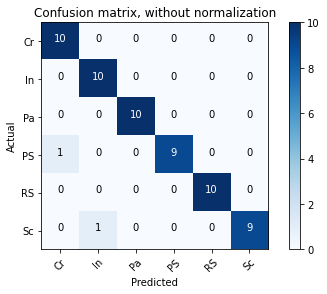

In [37]:
cnf_matrix = confusion_matrix(actual, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


### VGG16

In [ ]:
learn1 = cnn_learner(data, vgg16, pretrained=True, metrics=metrics)
# Below is needed since you get negative loss otherwise Ref: https://forums.fast.ai/t/negative-loss-with-letters-mnist/30889/15
# learn.loss_func = torch.nn.functional.cross_entropy
learn1.loss_func = nn.CrossEntropyLoss(weight=class_weights)

callbacks = [EarlyStoppingCallback(learn1, monitor='accuracy', min_delta=0.01, patience=3), SaveModelCallback(learn1, every='improvement', monitor='accuracy')]
learn1.callbacks = callbacks

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


By default, only the fully connected layers at the top are unfrozen (can be trained) (only in Fastai not Pytorch) ((i.e. requires_grad=False for all layers except FCN)

In [ ]:
learn1.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.319911,1.910482,0.103448,nan,0.321429,00:10
1,1.958246,1.237220,0.517241,nan,0.287594,00:03
2,1.551973,1.266010,0.551724,0.460714,0.604323,00:03
3,1.320657,1.307225,0.586207,0.658333,0.617481,00:03
4,1.090372,1.330631,0.586207,0.628125,0.706767,00:03
5,0.905562,1.332464,0.586207,nan,0.380639,00:03
6,0.773023,1.378348,0.586207,nan,0.380639,00:03


Better model found at epoch 0 with accuracy value: 0.1034482792019844.
Better model found at epoch 1 with accuracy value: 0.517241358757019.
Better model found at epoch 2 with accuracy value: 0.5517241358757019.
Better model found at epoch 3 with accuracy value: 0.5862069129943848.
Epoch 7: early stopping


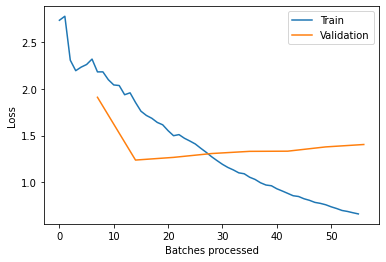

In [ ]:
learn1.recorder.plot_losses()

In [ ]:
# Get the predictions for validation set and store as numpy array
preds = learn1.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn1.get_preds()[1].numpy()

# Get the predictions for training set and store as numpy array
train_pred = learn1.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn1.get_preds(ds_type=DatasetType.Train)[1].numpy()

# Calculate accuracy_score and append to Dataframe
val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)

In [ ]:
val_acc, train_acc

(0.5862068965517241, 0.45535714285714285)

In [ ]:
confusion_matrix(test_actual, preds)

array([[13,  0,  0,  6],
       [ 0,  1,  0,  0],
       [ 2,  0,  2,  3],
       [ 0,  0,  1,  1]])

In [ ]:
confusion_matrix(train_actual, train_pred)

array([[43,  5, 15, 11],
       [ 3,  0,  1,  1],
       [13,  1,  7,  3],
       [ 4,  1,  3,  1]])

### ResNet50

In [ ]:
learn2 = cnn_learner(data, resnet50, pretrained=True, metrics=metrics)
learn2.loss_func = torch.nn.functional.cross_entropy

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


By default, only the fully connected layers at the top are unfrozen (can be trained) (only in Fastai not Pytorch) ((i.e. requires_grad=False for all layers except FCN)

In [ ]:
learn2.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.541088,1.394131,0.586207,nan,0.223684,00:08
1,2.066768,1.742163,0.482759,nan,0.421053,00:04
2,1.687377,1.428046,0.413793,nan,0.439850,00:04
3,1.333429,1.770467,0.310345,nan,0.163534,00:04
4,1.149831,1.601366,0.448276,0.320833,0.453008,00:04
5,0.954081,1.203817,0.689655,0.434722,0.567669,00:04
6,0.795043,1.015514,0.724138,0.750000,0.692669,00:04
7,0.664323,0.898260,0.620690,nan,0.281955,00:04
8,0.586723,0.944132,0.689655,nan,0.330827,00:04
9,0.507827,0.816107,0.689655,0.462500,0.420113,00:04


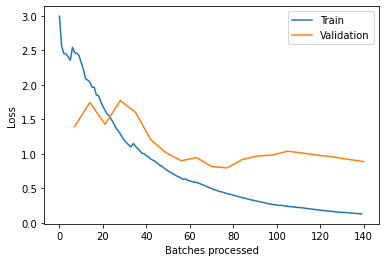

In [ ]:
learn2.recorder.plot_losses()

In [ ]:
# # Let's find the best learning rate
# learn2.unfreeze()
# learn2.lr_find()
# # Plot the learning rate
# learn2.recorder.plot()

In [ ]:
# learn.unfreeze()
# #learn.fit_one_cycle(4)
# learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [ ]:
# preds,y = learn2.get_preds()
# interp = ClassificationInterpretation.from_learner(learn2)
# interp.plot_confusion_matrix()  # wrong predictions for crack reduce at the cost of no crack

interp

In [ ]:
# Get the predictions for validation set and store as numpy array
preds = learn2.get_preds()[0].argmax(dim=-1).numpy()
test_actual = learn2.get_preds()[1].numpy()

# Get the predictions for training set and store as numpy array
train_pred = learn2.get_preds(ds_type=DatasetType.Train)[0].argmax(dim=-1).numpy()
train_actual = learn2.get_preds(ds_type=DatasetType.Train)[1].numpy()

# Calculate accuracy_score and append to Dataframe
val_acc = accuracy_score(test_actual, preds)
train_acc = accuracy_score(train_actual, train_pred)

In [ ]:
val_acc, train_acc

(0.7241379310344828, 0.5535714285714286)

In [ ]:
confusion_matrix(test_actual, preds)

array([[18,  1,  0,  0],
       [ 0,  0,  1,  0],
       [ 3,  1,  3,  0],
       [ 0,  0,  2,  0]])

In [ ]:
confusion_matrix(train_actual, train_pred)

array([[52,  1, 16,  4],
       [ 2,  1,  1,  1],
       [13,  3,  7,  2],
       [ 5,  1,  1,  2]])

# Data Augmentation

In [4]:
import os

os.listdir(r"C:\Users\Desktop\Projects\classification\Data\Data_Augmentation")

['NOK_Grind_Marks (1).bmp',
 'NOK_Grind_Marks (2).bmp',
 'NOK_Grind_Marks (3).bmp',
 'NOK_Grind_Marks (4).bmp',
 'NOK_Grind_Marks (5).bmp',
 'NOK_Induction (1).bmp',
 'NOK_Induction (10).bmp',
 'NOK_Induction (11).bmp',
 'NOK_Induction (12).bmp',
 'NOK_Induction (13).bmp',
 'NOK_Induction (14).bmp',
 'NOK_Induction (15).bmp',
 'NOK_Induction (16).bmp',
 'NOK_Induction (17).bmp',
 'NOK_Induction (18).bmp',
 'NOK_Induction (19).bmp',
 'NOK_Induction (2).bmp',
 'NOK_Induction (21).bmp',
 'NOK_Induction (22).bmp',
 'NOK_Induction (23).bmp',
 'NOK_Induction (24).bmp',
 'NOK_Induction (25).bmp',
 'NOK_Induction (26).bmp',
 'NOK_Induction (27).bmp',
 'NOK_Induction (28).bmp',
 'NOK_Induction (29).bmp',
 'NOK_Induction (30).bmp',
 'NOK_Induction (31).bmp',
 'NOK_Induction (32).bmp',
 'NOK_Induction (4).bmp',
 'NOK_Induction (5).bmp',
 'NOK_Induction (6).bmp',
 'NOK_Induction (8).bmp',
 'NOK_Induction (9).bmp',
 'NOK_Rust (1).bmp',
 'NOK_Rust (10).bmp',
 'NOK_Rust (11).bmp',
 'NOK_Rust (12).bmp

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.

'''
Image Augmentation is the common used technique to improve the performance of computer vision system. 
Refer to the W2 of Convolutional Neutral Network Course on Cousera. 
specially in the WIDS dataset, which is an unbalanced dataset. 
Upsampling the images with oil-palm is the way to handle the unbalanced problem. 
Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, 
such as mirroring, random rotation, shifts, shear and flips, etc. 
Keras has keras.preprocessing.image.ImageDataGenerator function to do image augmentation. Here showed how to use OpenCV to rotate, flip, and add Gaussian noise to original images.

Reference: 
https://towardsdatascience.com/image-augmentation-examples-in-python-d552c26f2873
https://medium.com/@thimblot/data-augmentation-boost-your-image-dataset-with-few-lines-of-python-155c2dc1baec

''' 

import cv2
import random
class Data_augmentation:
    def __init__(self, path, image_name):
        '''
        Import image
        :param path: Path to the image
        :param image_name: image name
        '''
        self.path = path
        self.name = image_name
        print(path+image_name)
        self.image = cv2.imread(path+image_name)

    def rotate(self, image, angle=90, scale=1.0):
        '''
        Rotate the image
        :param image: image to be processed
        :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
        :param scale: Isotropic scale factor.
        '''
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

    def flip(self, image, vflip=False, hflip=False):
        '''
        Flip the image
        :param image: image to be processed
        :param vflip: whether to flip the image vertically
        :param hflip: whether to flip the image horizontally
        '''
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 
    def image_augment(self, save_path): 
        '''
        Create the new image with imge augmentation
        :param path: the path to store the new image
        ''' 
        img = self.image.copy()
        img_flip = self.flip(img, vflip=True, hflip=False)
        img_rot = self.rotate(img)
        img_gaussian = self.add_GaussianNoise(img)
        print("image",img_rot)
        name_int = self.name[:len(self.name)-4]
        cv2.imwrite(save_path+'%s' %str(name_int)+'_vflip.jpg', img_flip)
        print(cv2.imwrite(save_path+'%s' %str(name_int)+'_rot.jpg', img_rot))
        cv2.imwrite(save_path+'%s' %str(name_int)+'_GaussianNoise.jpg', img_gaussian)
    
    

In [181]:
file_dir=r'C:\Users\Projects\classification\Data\Stain'
output_path = r'C:\Users\Projects\classification\Data\Augmented_Images\Stain'

In [179]:
# New Function
import os
def Augmentation(file_dir,output_path):
    for root, _, files in os.walk(file_dir):
        print(root)
    for file in files:
        name_int = file[:len(file)-4]
        Name=root+"\\"+file
        image = cv2.imread(Name)
        w = image.shape[1]
        h = image.shape[0]
        
#         #rotate matrix
#         M = cv2.getRotationMatrix2D((w/2,h/2), 90, 1)
#         #rotate
#         Rotation_image = cv2.warpAffine(image,M,(w,h))
#         cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_rotation.jpg', Rotation_image)
        
#         #Flipping the images Vertically
#         vflip=True
#         hflip=False
#         if hflip or vflip:
#             if hflip and vflip:
#                 c = -1
#             else:
#                 c = 0 if vflip else 1
#             Flipped_image = cv2.flip(image, flipCode=c)
#         cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_vflip.jpg', Flipped_image)
        
#         #Flipping the images Horizontally
#         vflip=False
#         hflip=True
#         if hflip or vflip:
#             if hflip and vflip:
#                 c = -1
#             else:
#                 c = 0 if vflip else 1
#             Flipped_image = cv2.flip(image, flipCode=c)
#         cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_hflip.jpg', Flipped_image)
        
        #Channel Shift
        value = int(random.uniform(-60, 60))
        img = image + value
        img[:,:,:][img[:,:,:]>255]  = 255
        img[:,:,:][img[:,:,:]<0]  = 0
        Channel_Shift_img = img.astype(np.uint8)
        cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_ChannelShift.jpg', Channel_Shift_img)
        
        #To increase the Brightness
        value = random.uniform(0.5, 3)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv = np.array(hsv, dtype = np.float64)
        hsv[:,:,1] = hsv[:,:,1]*value
        hsv[:,:,1][hsv[:,:,1]>255]  = 255
        hsv[:,:,2] = hsv[:,:,2]*value 
        hsv[:,:,2][hsv[:,:,2]>255]  = 255
        hsv = np.array(hsv, dtype = np.uint8)
        Brightness_Image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        cv2.imwrite(output_path+"\\"+'%s' %str(name_int)+'_Brightness.jpg', Channel_Shift_img)

       
        

In [ ]:
Augmentation(file_dir,output_path)